### imports

In [1]:
# Import necessary modules
from tvb.simulator.lab import *
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from scipy.signal import spectrogram, butter, filtfilt, hilbert, welch, coherence, correlate
from itertools import combinations
import seaborn as sns

# Load Structural Connectivity Matrix
con = connectivity.Connectivity.from_file('/Users/mac/Downloads/tvb_data/tvb_data/connectivity/connectivity_76.zip')
nregions = len(con.region_labels)
con.weights = con.weights - con.weights * np.eye(nregions)  # Remove self-connections
con.speed = np.array([sys.float_info.max])  # Neglect conduction speed
con.configure()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


2024-09-07 20:23:58,880 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [2]:
# Extract region labels
region_labels = con.region_labels

# Get the labels for the specific indices
selected_regions = region_labels[[62, 40, 47, 69, 72]]

# Display the selected regions
print("Selected brain regions:", selected_regions)

Selected brain regions: ['lPHC' 'lAMYG' 'lHC' 'lTCI' 'lTCV']


### connectivity matrix visualization

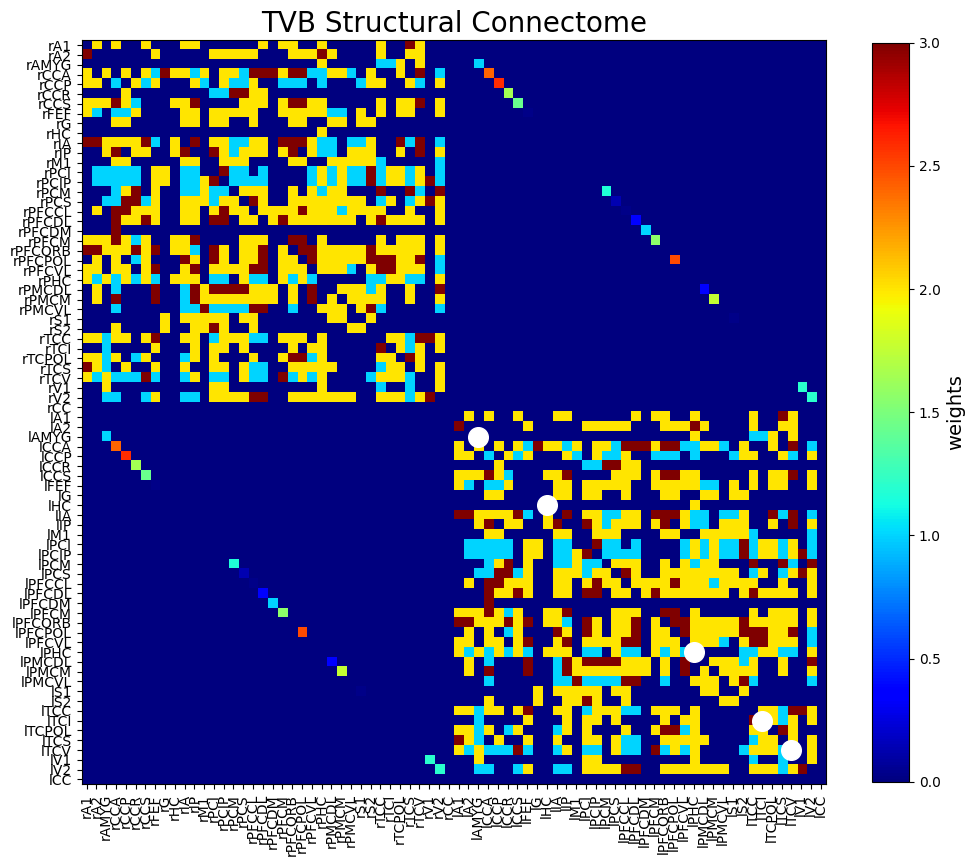

In [3]:
# Visualize the Structural Connectome
plt.figure(figsize=(12,12))
plt.imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), con.region_labels, fontsize=10, rotation=90)
plt.yticks(range(0, nregions), con.region_labels, fontsize=10)
cb = plt.colorbar(shrink=0.8)
cb.set_label('weights', fontsize=14)
plt.scatter([62, 40, 47, 69, 72], [62, 40, 47, 69, 72], c='w', marker='o', s=200, edgecolor='w', label='Electrode Sites')

plt.show()

### connectivity weights between electrodes

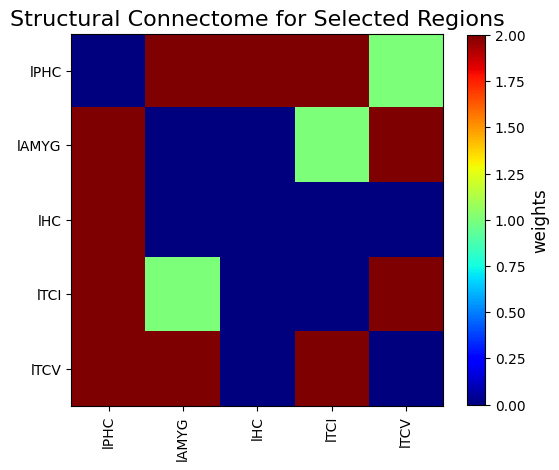

In [4]:
# Get the indices of the selected regions
selected_indices = [62, 40, 47, 69, 72]

# Extract the submatrix corresponding to the selected regions
submatrix = con.weights[np.ix_(selected_indices, selected_indices)]

# Plot the submatrix for the selected regions
plt.figure(figsize=(6,6))
plt.imshow(submatrix, interpolation='nearest', aspect='equal', cmap ="jet")
plt.title('Structural Connectome for Selected Regions', fontsize=16)
plt.xticks(range(len(selected_regions)), selected_regions, fontsize=10, rotation=90)
plt.yticks(range(len(selected_regions)), selected_regions, fontsize=10)
cb = plt.colorbar(shrink=0.8)
cb.set_label('weights', fontsize=12)
plt.show()


### initialize hybrid epileptor model

In [5]:
mod = EpileptorRestingState(Ks=np.array([-0.1]), r=np.array([0.000015]), tau=np.array([1000]), K_rs=np.array([0.1]))
mod.a_rs = np.ones((nregions)) * (1.7402)

# Define Epileptogenic Network (EZ, PZ, NIZ)
mod.x0 = np.ones((nregions)) * (-2.3)  # NIZ
mod.x0[[40]] = np.ones((1)) * (-1.4)   # EZ: lAMYG
mod.x0[[47, 62]] = np.ones((2)) * (-1.6)  # EZ: lHC, lPHC
mod.x0[[69]] = np.ones((1)) * (-1.7)   # PZ: lTCI
mod.x0[[72]] = np.ones((1)) * (-1.8)   # PZ: lTCV

mod.bb = np.ones((nregions)) * (4)     # NIZ
mod.bb[[40, 47, 62]] = np.ones((3)) * (1)  # EZ
mod.bb[[69, 72]] = np.ones((2)) * (2)  # PZ

mod.p = np.ones((nregions)) * (0.1)    # NIZ
mod.p[[40, 47, 62]] = np.ones((3)) * (0.9)  # EZ
mod.p[[69, 72]] = np.ones((2)) * (0.7)  # PZ

#  Set up the Coupling Function
coupl = 1
con_coupling = coupling.Difference(a=np.array([coupl]))


# add noise
dt = 0.1  # Integration step size [ms]
nsigma1 = 0.00025  # Noise standard deviation for x2 and y2
nsigma2 = 0.001  # Noise standard deviation for x_rs

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma1, nsigma1, 0., nsigma2, 0.]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

#  Define Monitors
mon_tavg = monitors.TemporalAverage(period=1)  # Monitor with 1ms period
what_to_watch = mon_tavg

### run simulator 
this creates the EEG data for 60 seconds with increased probability of a seizure occusing

In [6]:
# Set up the Simulator
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch])
sim.configure()

# Run the Simulation
simulation_length = 60000  # Simulation length in ms
tic = tm.time()

tavg_time, tavg_data = [], []
for tavg in sim(simulation_length=simulation_length):
    if tavg is not None:
        tavg_time.append(tavg[0][0])
        tavg_data.append(tavg[0][1])

print(f'Simulation required {tm.time()-tic:.3f} seconds.')


/var/folders/v7/dbllwbmn3qv0sk0spbzgpd440000gn/T/ipykernel_64575/3426791091.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conduction_speed=np.float64(con.speed),


Simulation required 78.672 seconds.


### visualize results

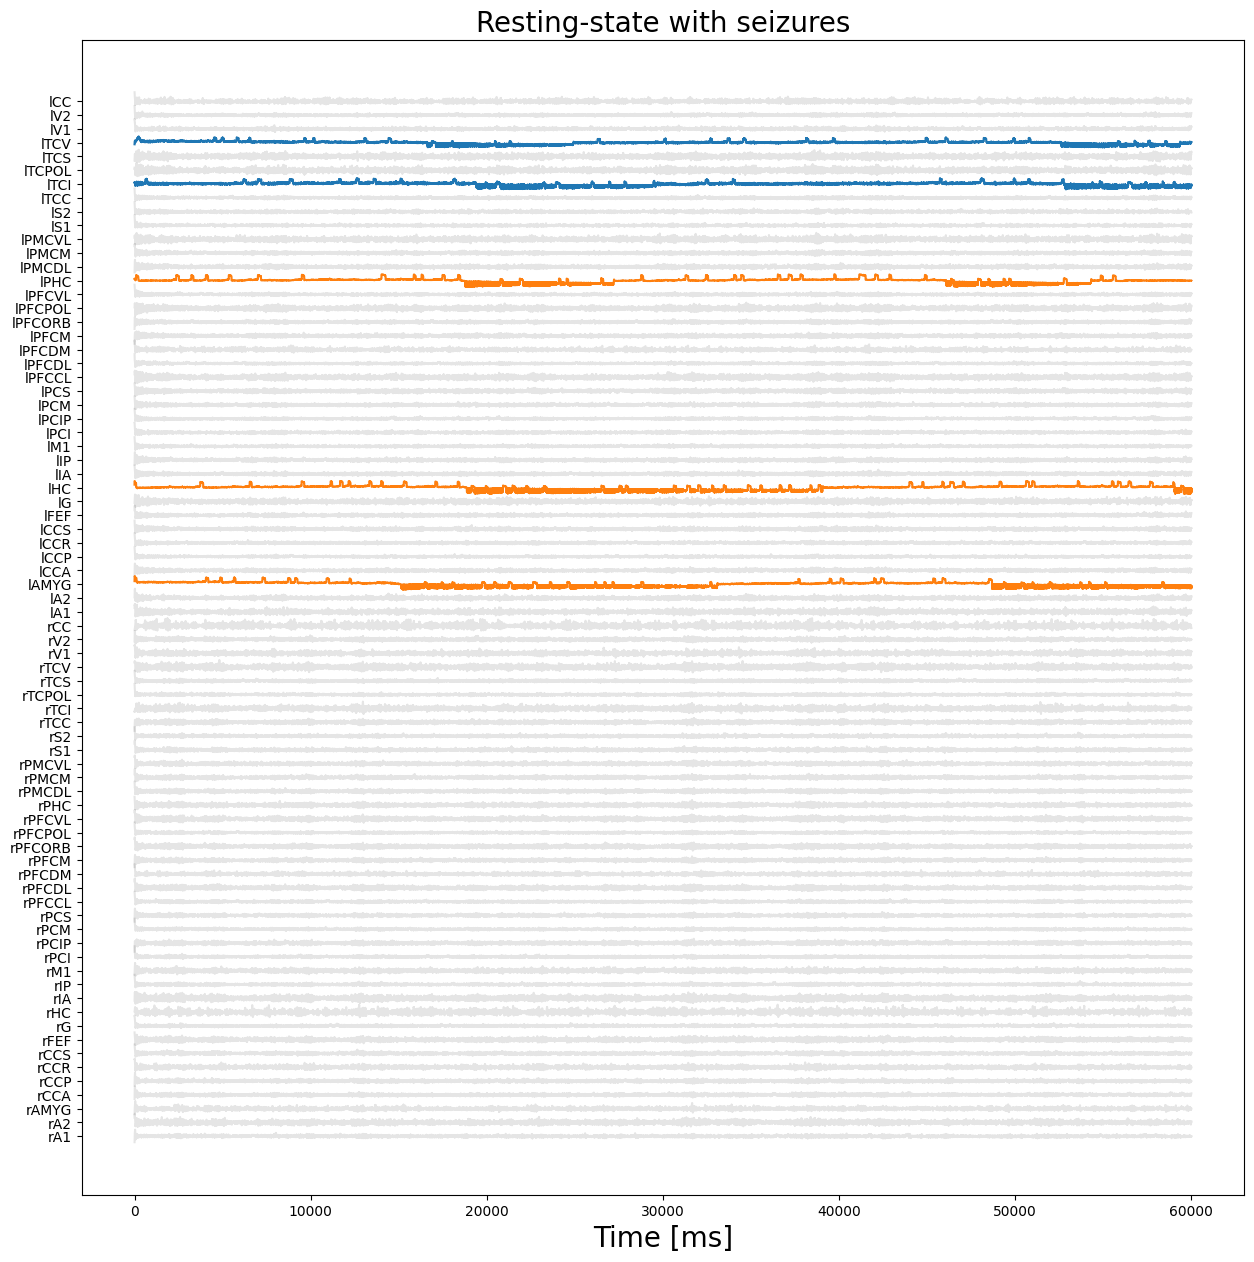

In [7]:
# Process and Visualize Simulation Results
tavg_data = np.squeeze(np.array(tavg_data))
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))
tavg_data -= np.mean(tavg_data, 0)

# Compute LFP output model
DATA = mod.p[[0]] * tavg_data[:, 0, :] + (1 - mod.p[[0]]) * tavg_data[:, 2, :]

EZs = [62, 47, 40]
PZs = [69, 72]
for ie, ez in enumerate(EZs):
    DATA[:, EZs[ie]] = mod.p[[EZs[ie]]] * tavg_data[:, 0, EZs[ie]] + (1 - mod.p[[EZs[ie]]]) * tavg_data[:, 2, EZs[ie]]
for ip, pz in enumerate(PZs):
    DATA[:, PZs[ip]] = mod.p[[PZs[ip]]] * tavg_data[:, 0, PZs[ip]] + (1 - mod.p[[PZs[ip]]]) * tavg_data[:, 2, PZs[ip]]

# Plot time series
plt.figure(figsize=(15,15))
plt.plot(DATA[:, :] + np.r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

for ie, ez in enumerate(EZs):
    plt.plot(DATA[:, EZs[ie]] + EZs[ie], 'C1')
for ip, pz in enumerate(PZs):
    plt.plot(DATA[:, PZs[ip]] + PZs[ip], 'C0')

plt.title('Resting-state with seizures', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.show()


### epileptogenic network time series

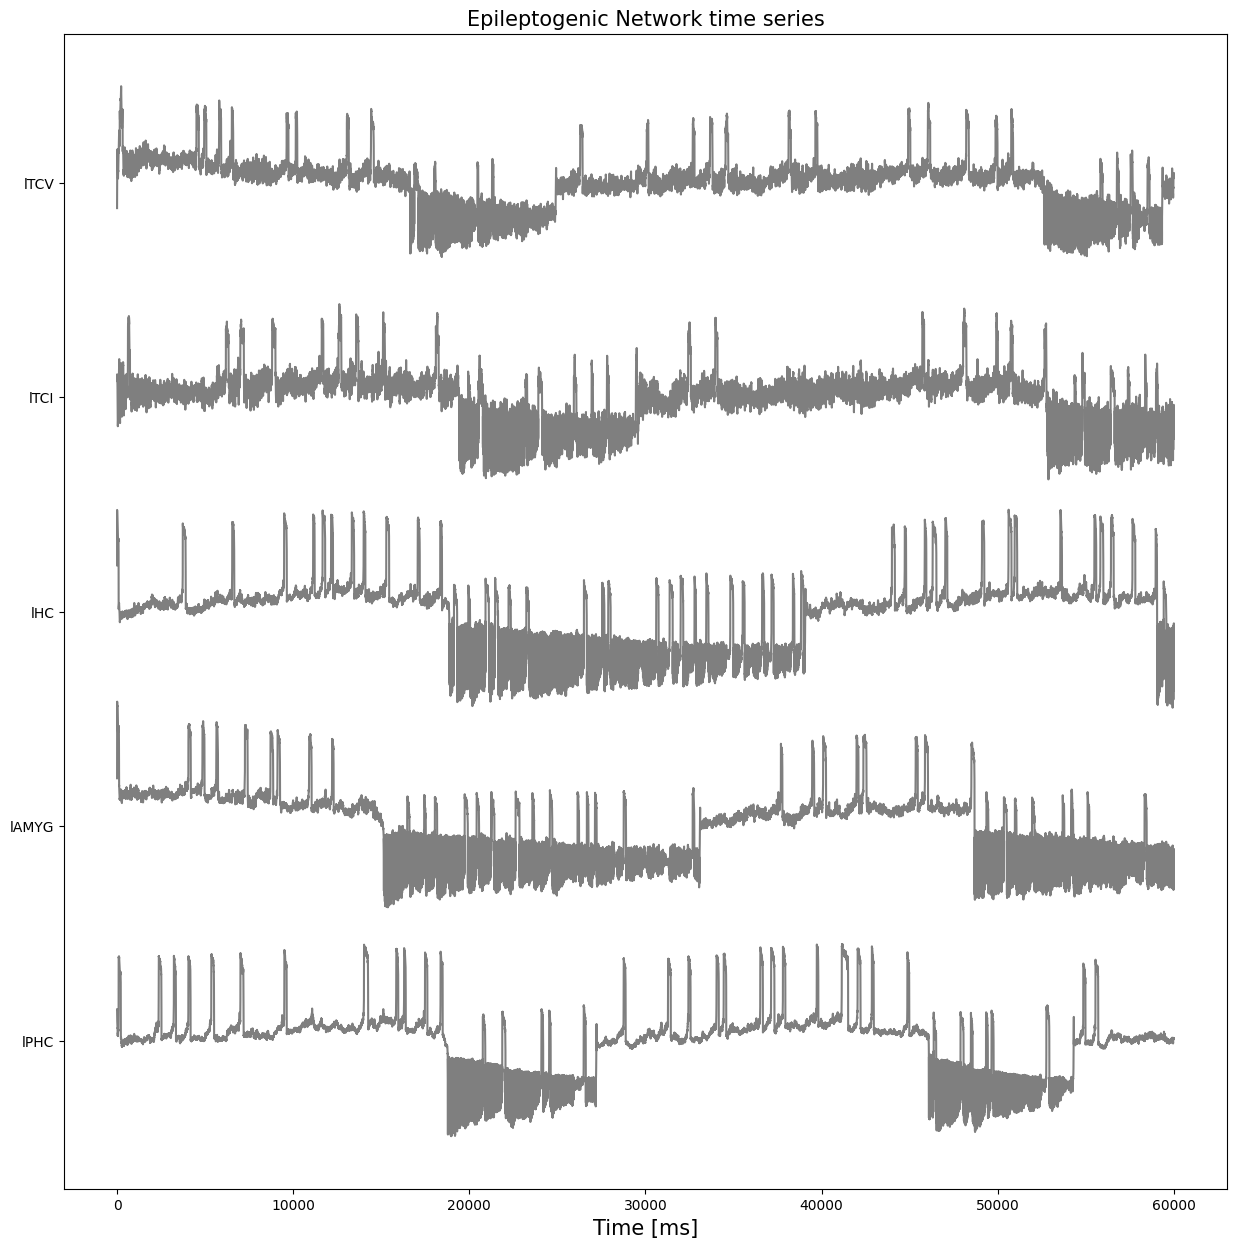

In [8]:
# Epileptogenic Network time series
EN = [62, 40, 47, 69, 72]
plt.figure(figsize=(15,15))
for ie, en in enumerate(EN):
    plt.plot(np.arange(0, 60000), DATA[0:60000, EN[ie]] + ie, 'k', alpha=0.5)
plt.title('Epileptogenic Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(EN)), con.region_labels[EN])
plt.show()

### comparison to non-seizure areas

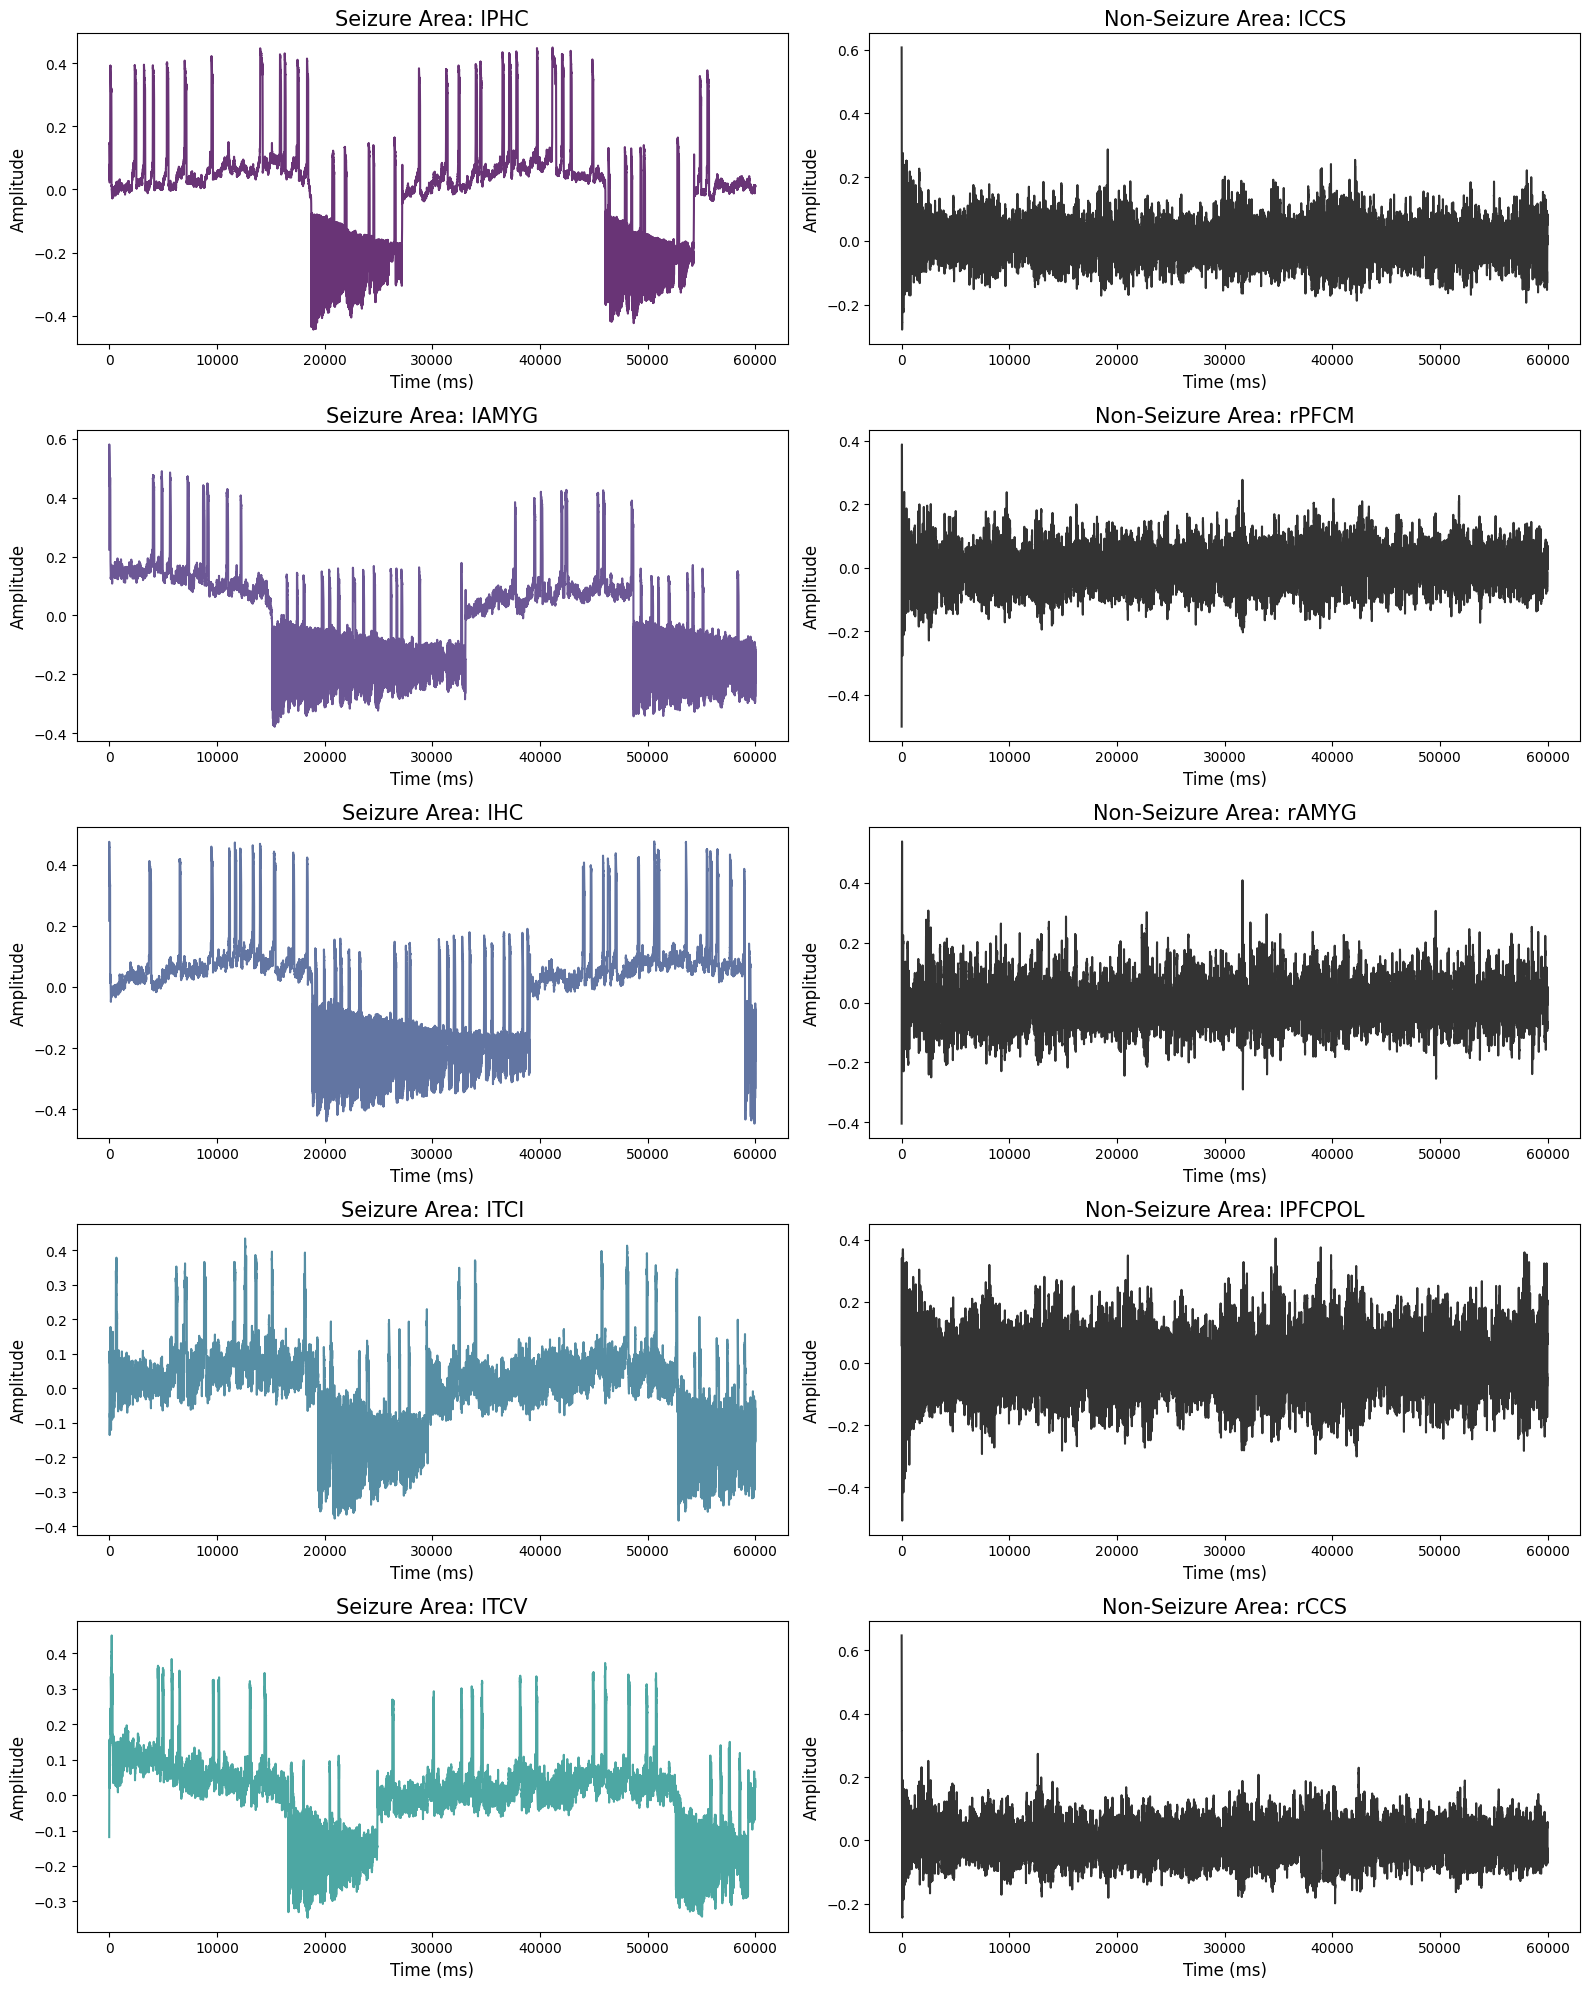

In [9]:

# Define the seizure regions and corresponding colors
seizure_regions = [62, 40, 47, 69, 72]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV']
colors = plt.cm.viridis(np.linspace(0, .5, len(seizure_regions)))  # Use the same colormap as before

# Generate 5 random non-seizure regions that are not in the seizure list
nregions = DATA.shape[1]
all_regions = list(range(nregions))
non_seizure_regions = np.random.choice([r for r in all_regions if r not in seizure_regions], 5, replace=False)

# Create a figure with 2 columns and 5 rows
fig, axs = plt.subplots(5, 2, figsize=(16, 20))

# Plot each seizure region on the left side with corresponding colors
for i, (region_idx, color) in enumerate(zip(seizure_regions, colors)):
    axs[i, 0].plot(DATA[:, region_idx], color=color, alpha=0.8)
    axs[i, 0].set_title(f'Seizure Area: {names[i]}', fontsize=15)
    axs[i, 0].set_xlabel('Time (ms)', fontsize=12)
    axs[i, 0].set_ylabel('Amplitude', fontsize=12)

# Plot each non-seizure region on the right side with black color
for i, region_idx in enumerate(non_seizure_regions):
    axs[i, 1].plot(DATA[:, region_idx], 'k', alpha=0.8)
    axs[i, 1].set_title(f'Non-Seizure Area: {con.region_labels[region_idx]}', fontsize=15)
    axs[i, 1].set_xlabel('Time (ms)', fontsize=12)
    axs[i, 1].set_ylabel('Amplitude', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### mean temporal average (MTA), fast fourier tranform (FFT) and power spectral density (PSD) plotted over time

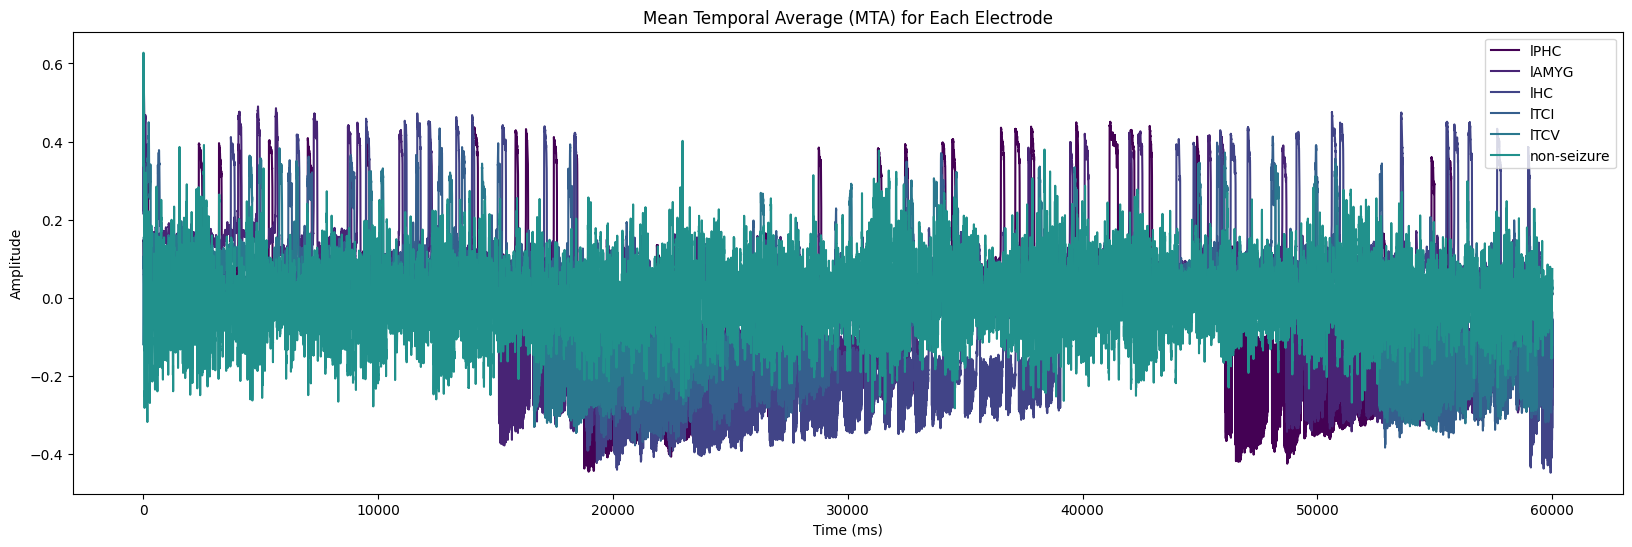

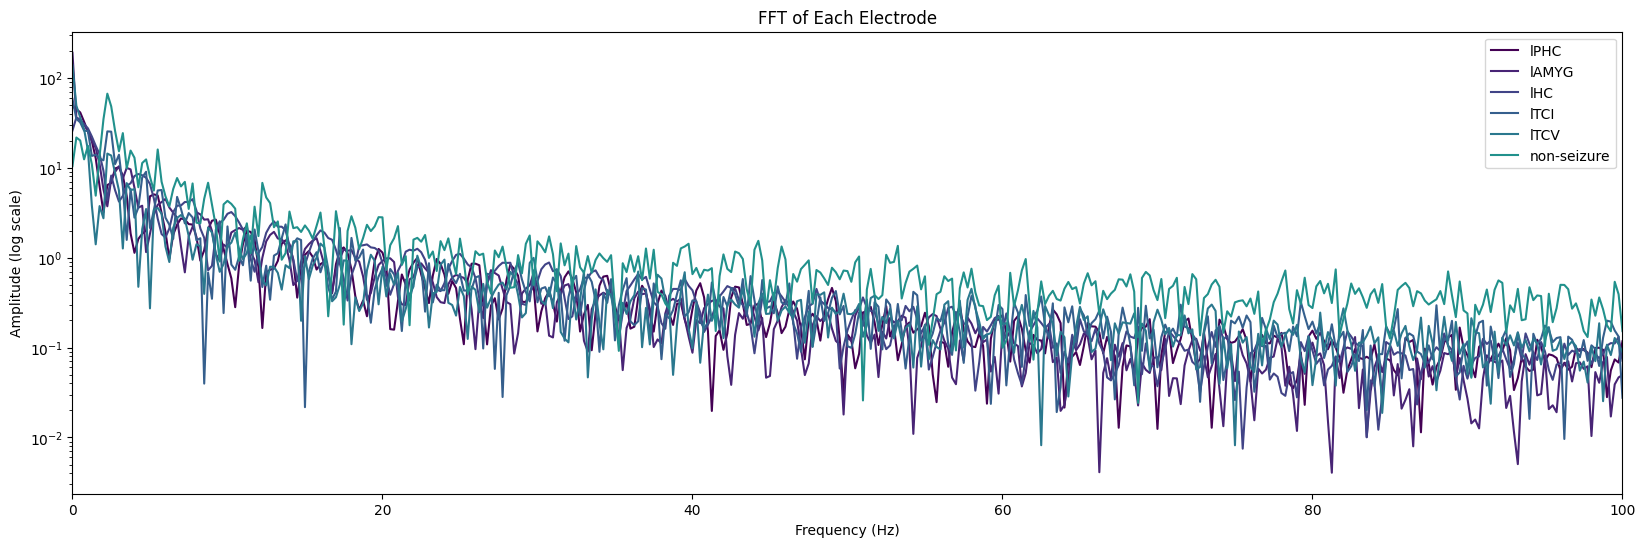

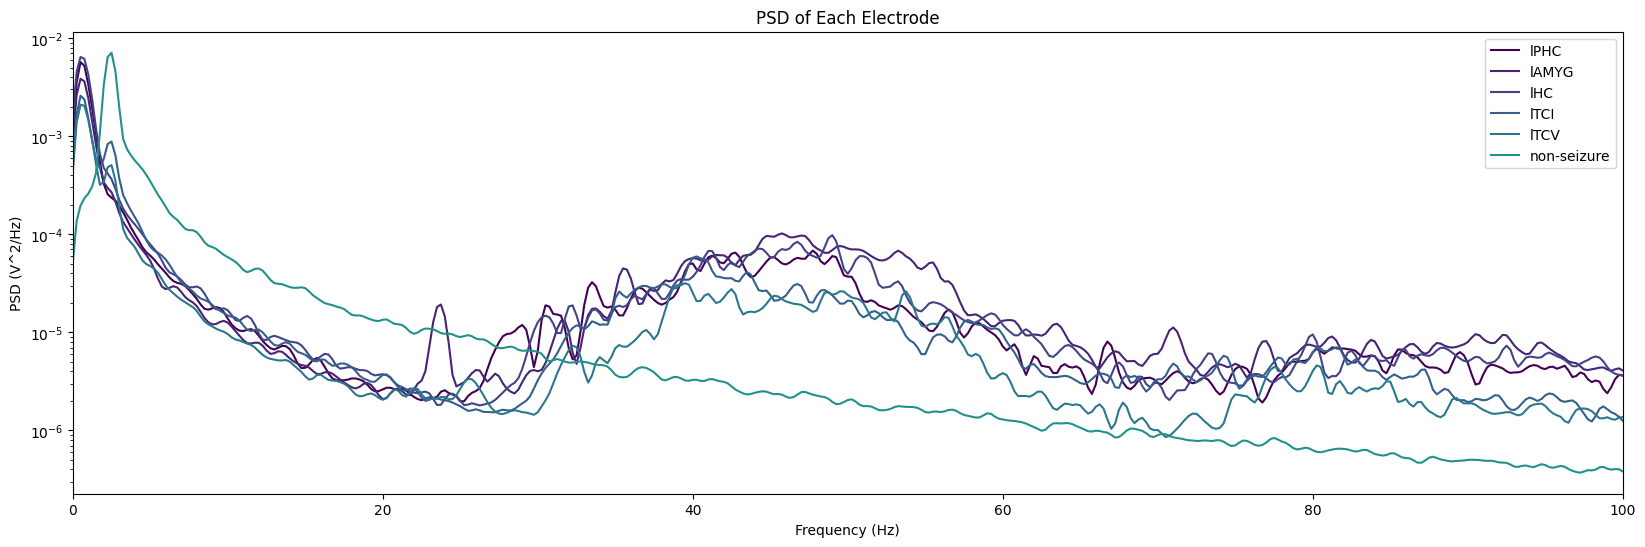

In [10]:
# Define the electrodes and their corresponding names
EN = [62, 40, 47, 69, 72, 1]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV', 'non-seizure']
colors = plt.cm.viridis(np.linspace(0, .5, len(EN)))  # Use a colormap to generate distinct colors

# Plot Mean Temporal Average
plt.figure(figsize=(20, 6))
for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]
    plt.plot(np.arange(0, len(electrode_data)), electrode_data, color=color, label=name)

plt.title('Mean Temporal Average (MTA) for Each Electrode')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot FFT
plt.figure(figsize=(20, 6))
for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]

    # Perform FFT with higher resolution
    nfft = 2**10  # Using 1024 points for FFT for finer frequency resolution
    fft = np.fft.fft(electrode_data, n=nfft)
    freq = np.fft.fftfreq(nfft, d=1/256)

    # Filter to keep only frequencies between 0 and 100 Hz
    pos_freqs = (freq >= 0) & (freq <= 100)
    pos_freqs_fft = fft[pos_freqs]
    pos_freqs_freq = freq[pos_freqs]

    # Plot FFT of Mean Temporal Average
    plt.plot(pos_freqs_freq, np.abs(pos_freqs_fft), color=color, label=name)

plt.title('FFT of Each Electrode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (log scale)')
plt.yscale('log')  # Use logarithmic scale for amplitude
plt.xlim(0, 100)
plt.legend()
plt.show()

# Plot PSD
plt.figure(figsize=(20, 6))
for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]

    # Calculate the PSD using Welch's method with higher resolution
    freqs, psd = welch(electrode_data, fs=256, nperseg=nfft//2, noverlap=nfft//4, nfft=nfft)

    # Filter the PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]

    # Plot PSD of Mean Temporal Average
    plt.semilogy(freqs, psd, color=color, label=name)

plt.title('PSD of Each Electrode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.xlim(0, 100)
plt.legend()
plt.show()

### MTA, FFT, PSD by electrode


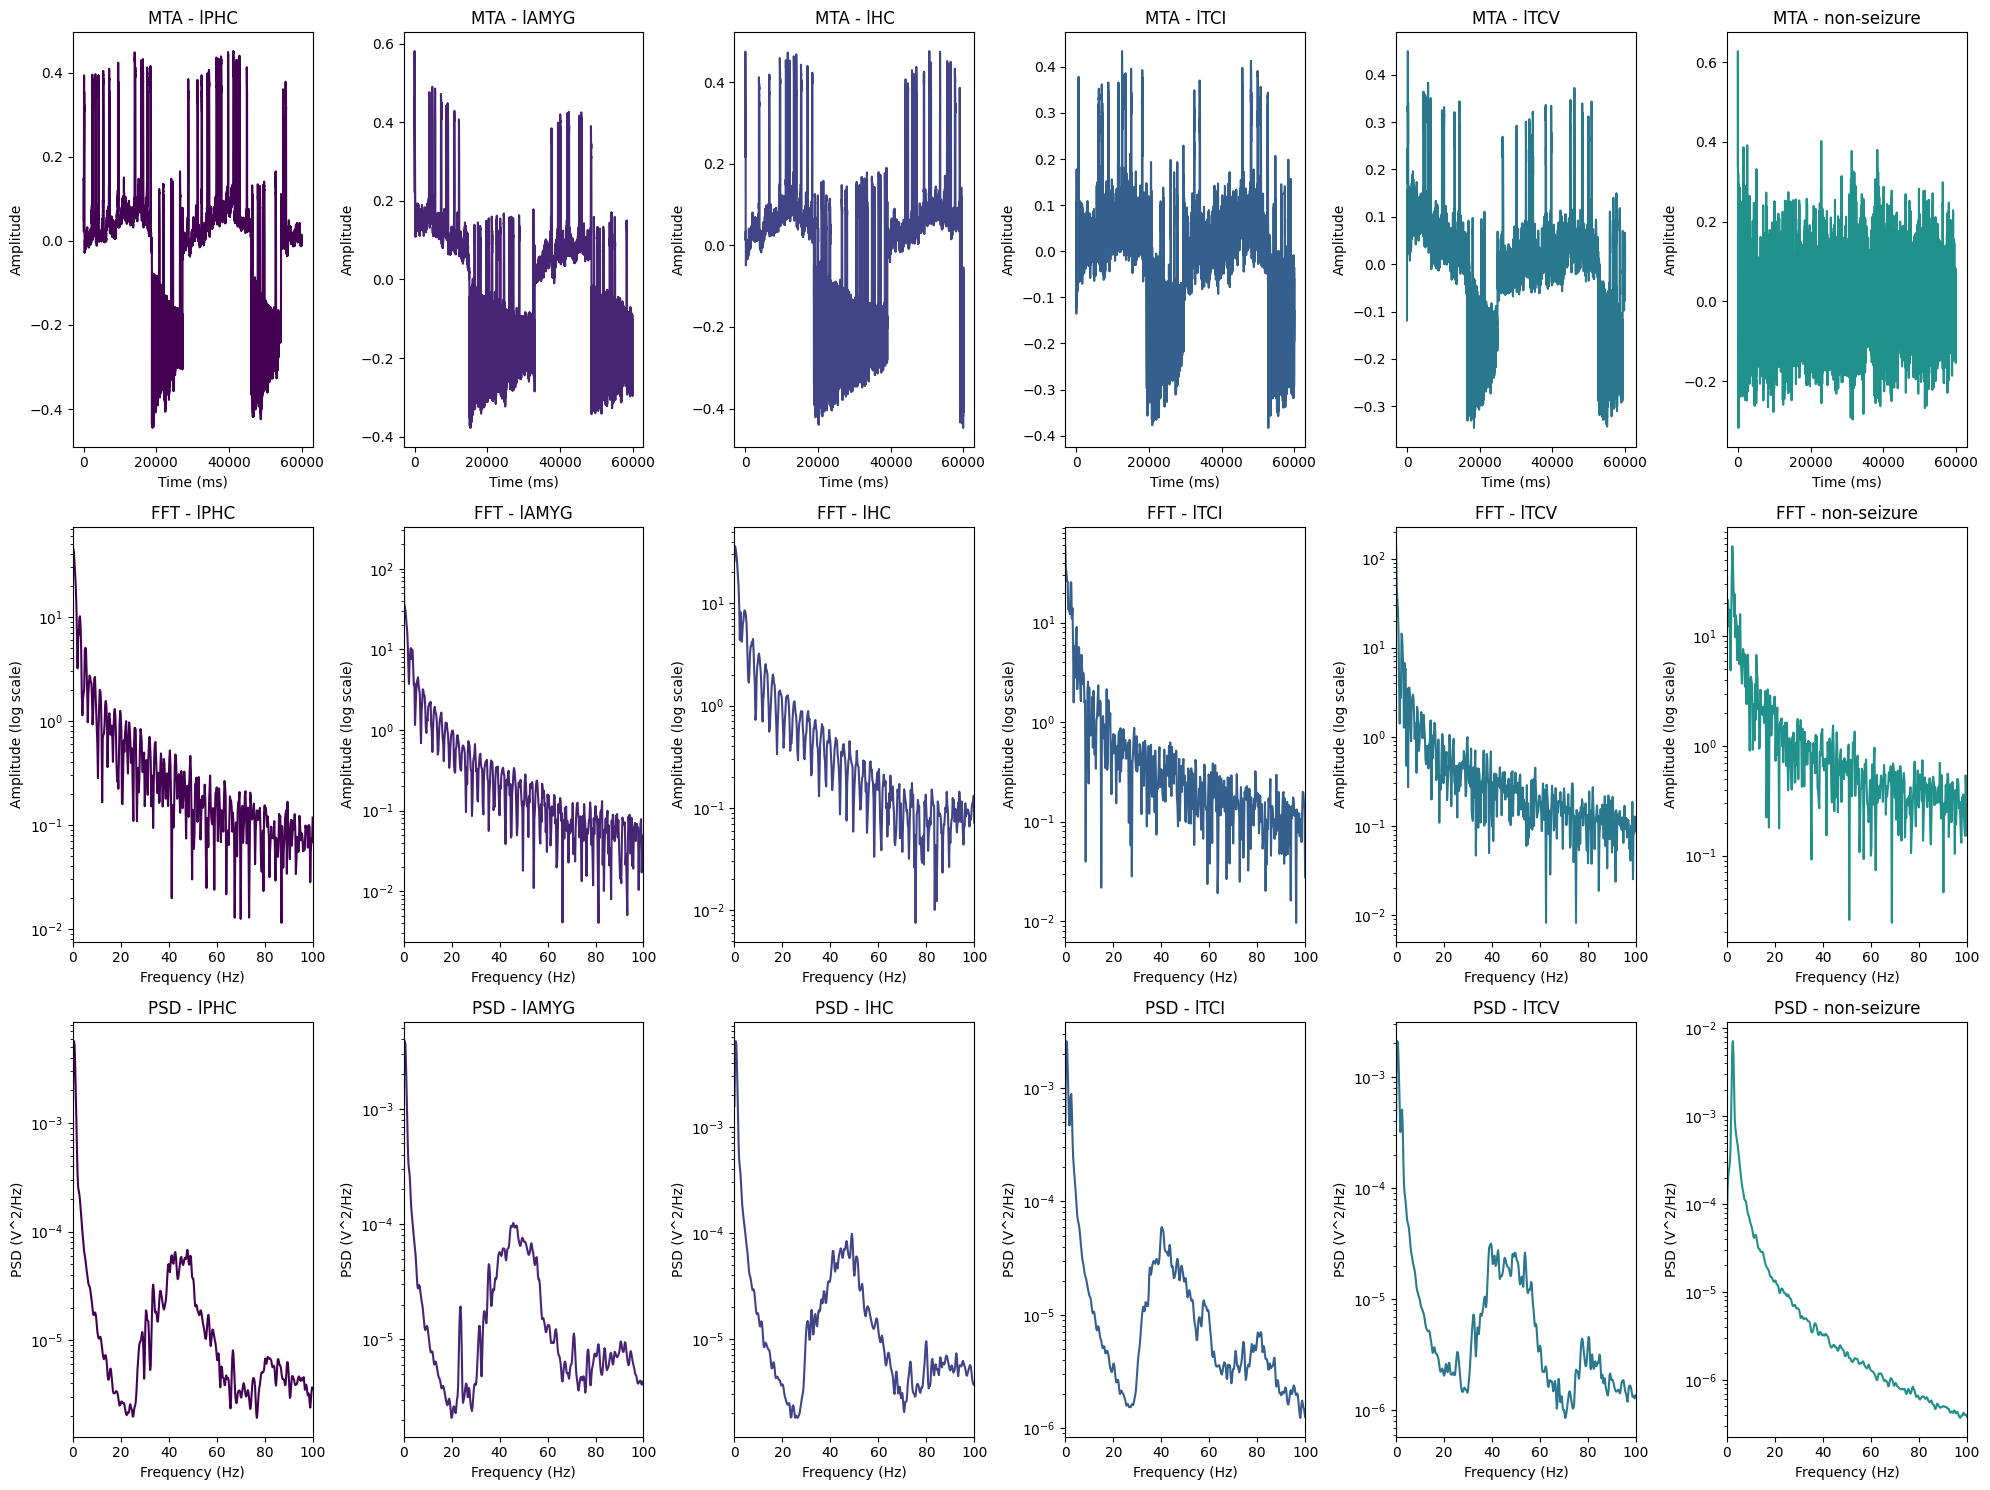

In [11]:
EN = [62, 40, 47, 69, 72, 1]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV', 'non-seizure']
colors = plt.cm.viridis(np.linspace(0, .5, len(EN)))  # Use a colormap to generate distinct colors

plt.figure(figsize=(20, 15))

for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]

    # Perform FFT with higher resolution
    nfft = 2**10  # Using 1024 points for FFT for finer frequency resolution
    fft = np.fft.fft(electrode_data, n=nfft)
    freq = np.fft.fftfreq(nfft, d=1/256)

    # Filter to keep only frequencies between 0 and 100 Hz
    pos_freqs = (freq >= 0) & (freq <= 100)
    pos_freqs_fft = fft[pos_freqs]
    pos_freqs_freq = freq[pos_freqs]

    # Calculate the PSD using Welch's method with higher resolution
    freqs, psd = welch(electrode_data, fs=256, nperseg=nfft//2, noverlap=nfft//4, nfft=nfft)

    # Filter the PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]

    # Plot Mean Temporal Average
    plt.subplot(3, len(EN), idx + 1)
    plt.plot(np.arange(0, len(electrode_data)), electrode_data, color=color)
    plt.title(f'MTA - {name}')
    plt.ylabel("Amplitude")
    plt.xlabel('Time (ms)')
  
    # Plot FFT of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, len(EN), len(EN) + idx + 1)
    plt.plot(pos_freqs_freq, np.abs(pos_freqs_fft), color=color)
    plt.yscale('log')  # Use logarithmic scale for amplitude
    plt.xlim(0, 100)
    plt.title(f'FFT - {name}')
    plt.ylabel('Amplitude (log scale)')
    plt.xlabel('Frequency (Hz)')

    # Plot PSD of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, len(EN), 2 * len(EN) + idx + 1)
    plt.semilogy(freqs, psd, color=color)
    plt.title(f'PSD - {name}')
    plt.xlim(0, 100)
    plt.ylabel('PSD (V^2/Hz)')
    plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

### average Phase Synchronization Index (PSI) on average

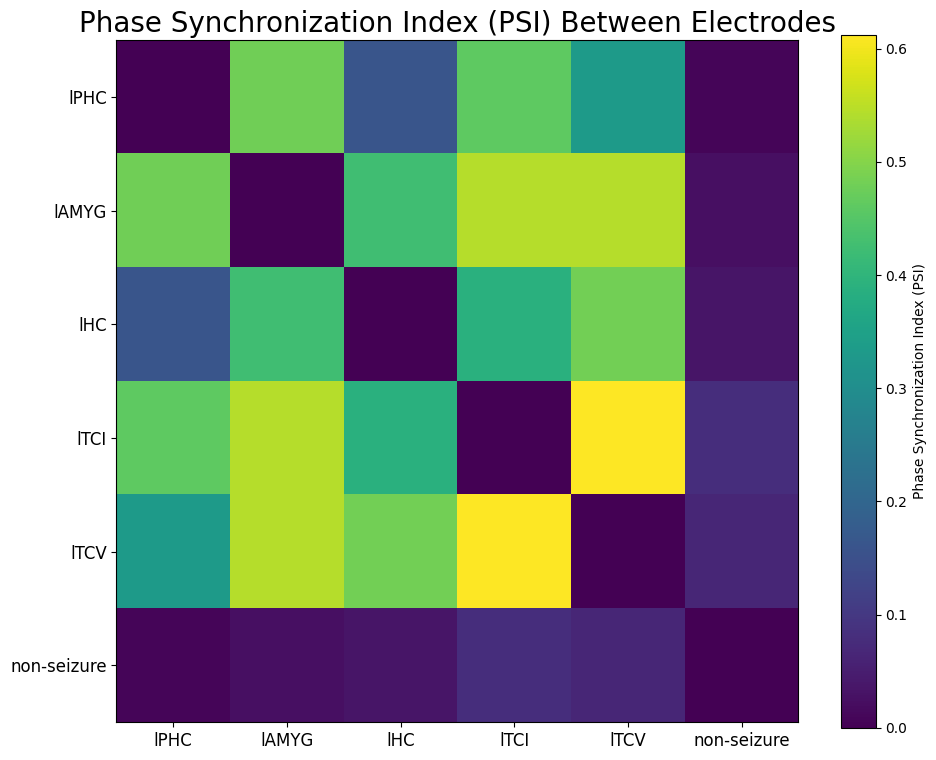

In [12]:
# Extract the signals for the electrodes
electrode_signals = DATA[:, EN]

# Compute the analytic signal and phase for each electrode
analytic_signal = hilbert(electrode_signals, axis=0)
instantaneous_phase = np.angle(analytic_signal)

# Initialize the Phase Synchronization Index (PSI) matrix
psi_matrix = np.zeros((len(EN), len(EN)))

# Compute the PSI between each pair of electrodes
for i in range(len(EN)):
    for j in range(i+1, len(EN)):
        # Compute phase difference
        phase_diff = instantaneous_phase[:, i] - instantaneous_phase[:, j]
        # Compute PSI as the average of the cosine of the phase differences
        psi_matrix[i, j] = np.abs(np.mean(np.exp(1j * phase_diff)))
        psi_matrix[j, i] = psi_matrix[i, j]  # Symmetric matrix

# Visualize the PSI matrix as a heatmap
plt.figure(figsize=(11, 9))
plt.imshow(psi_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Phase Synchronization Index (PSI)')
plt.title('Phase Synchronization Index (PSI) Between Electrodes', fontsize=20)
plt.xticks(range(len(EN)), names, fontsize=12)
plt.yticks(range(len(EN)), names, fontsize=12)
plt.show()

### raw time series and channel PSI for each electrode
plotting the raw time series, and an aligned visualization of the channel time series and the phase synchronization index (PSI) heatmaps

theta: (4,8)

alpha: (8,12)

beta: (13,30)

gamma: (30,40)

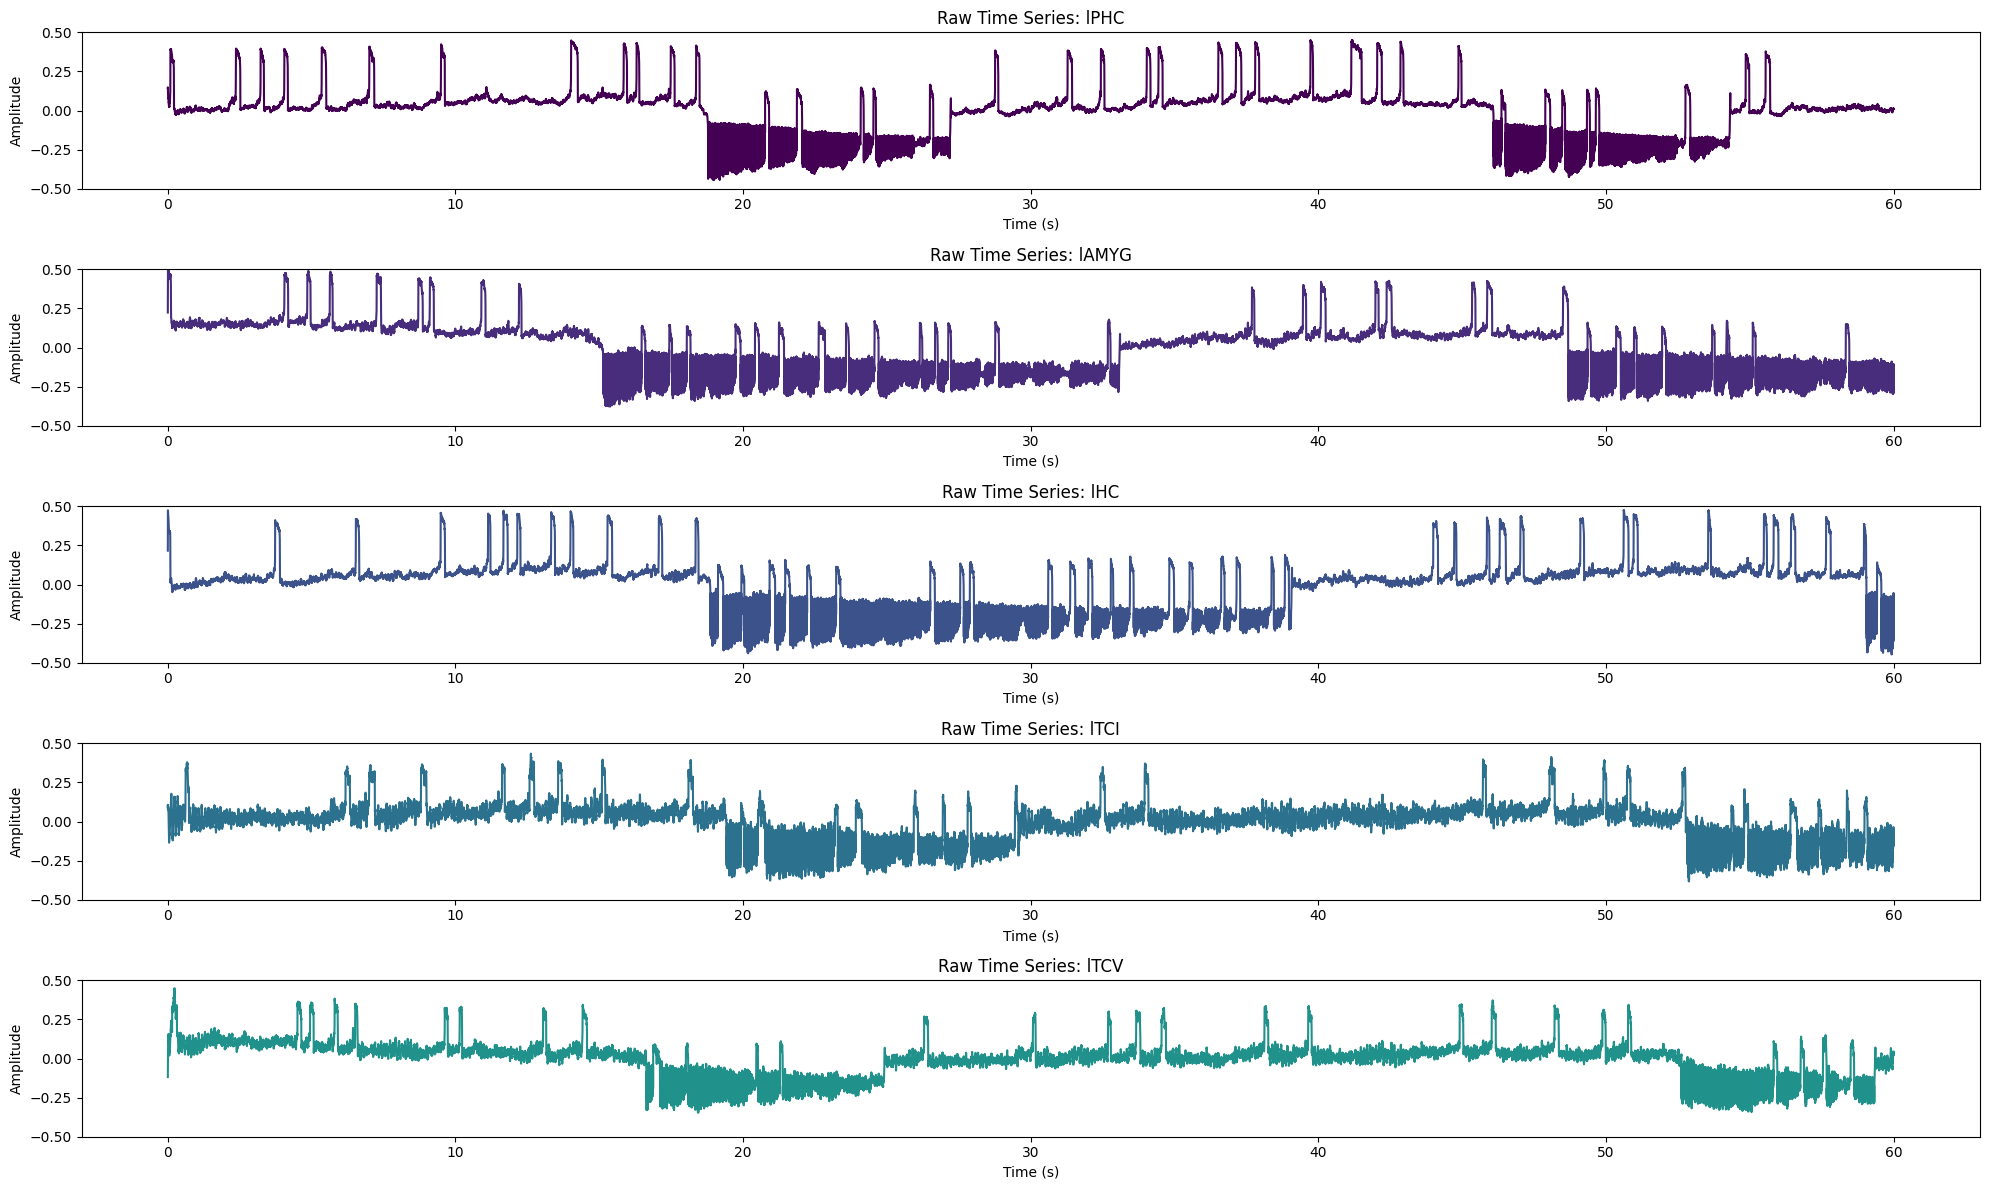

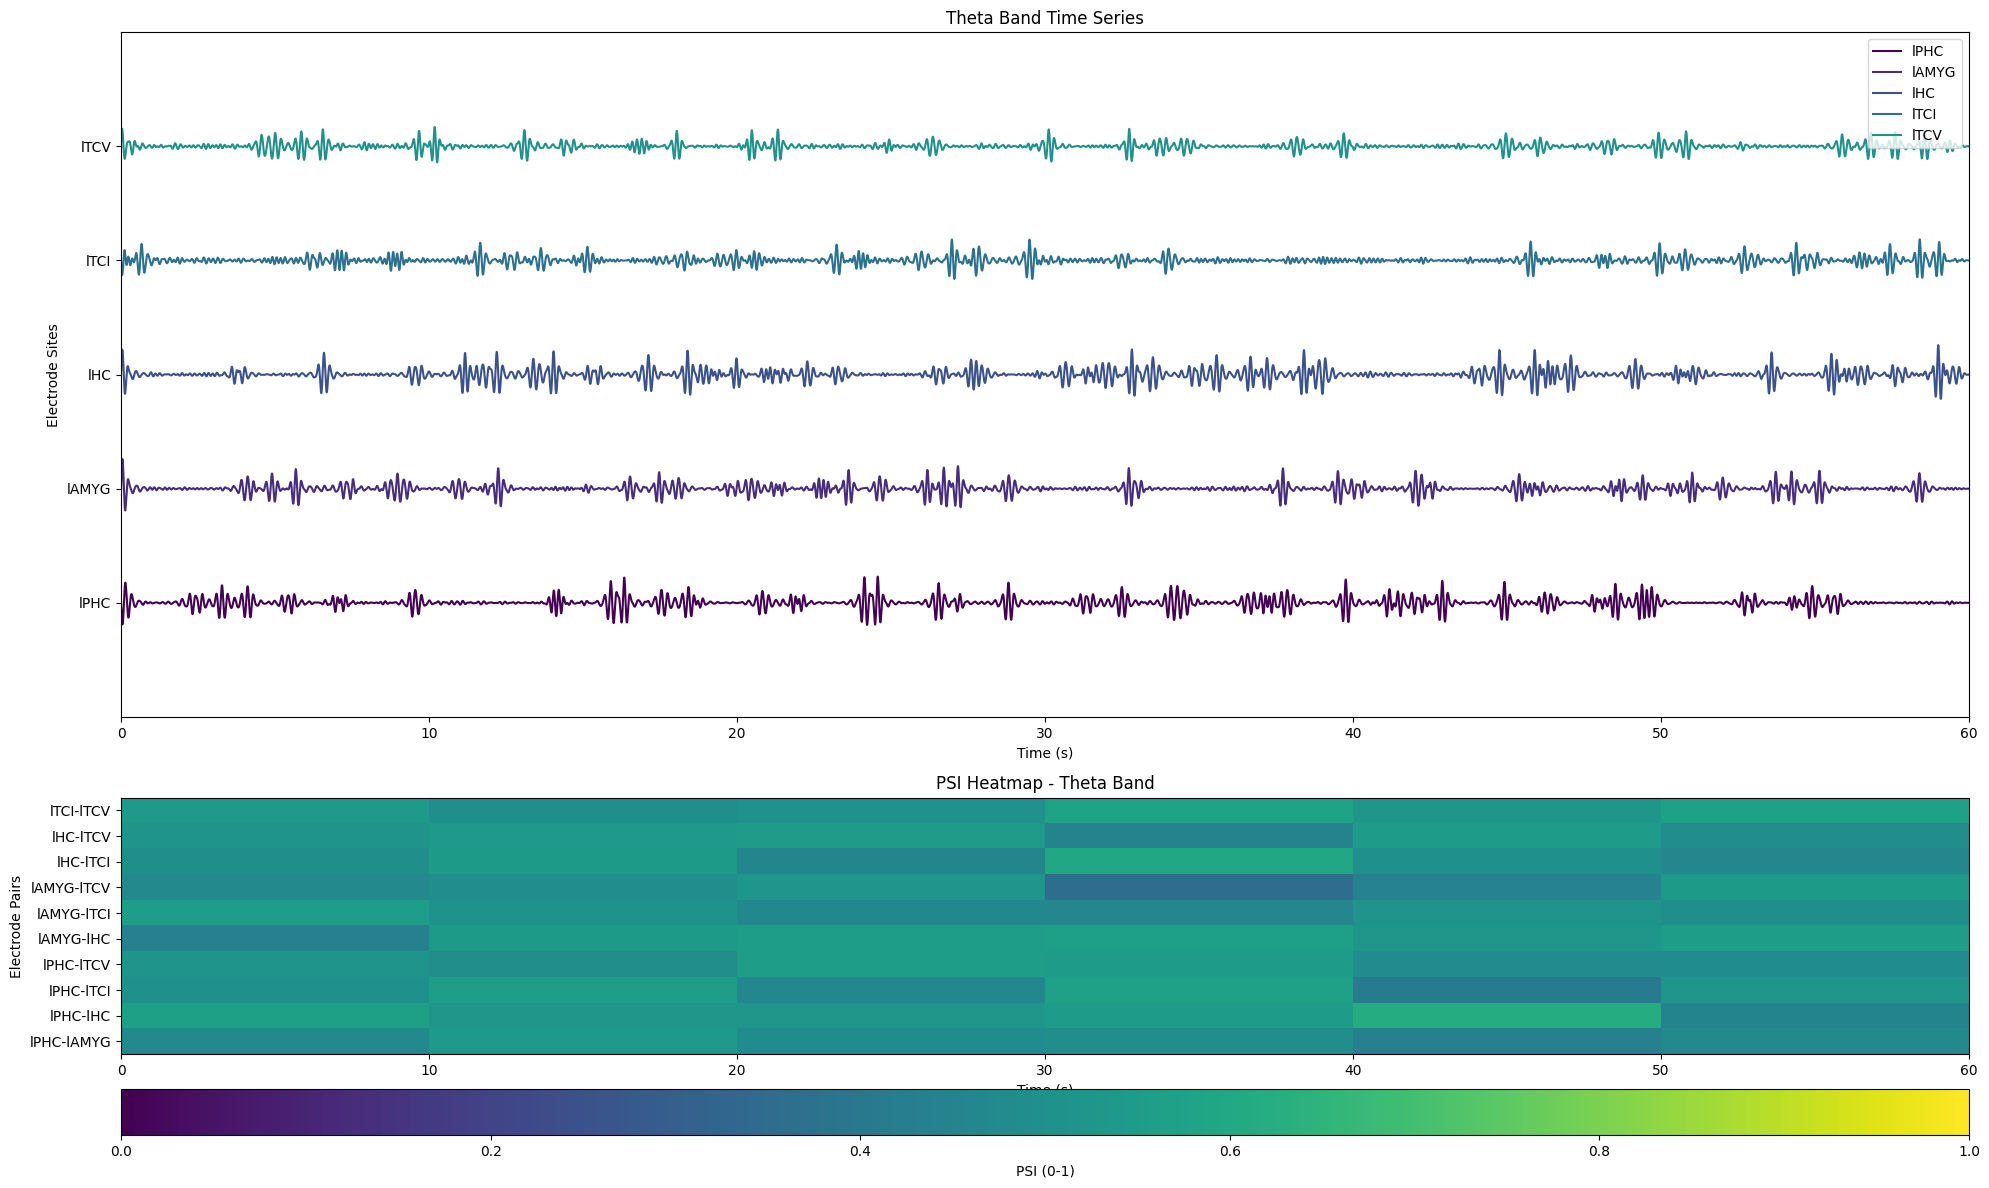

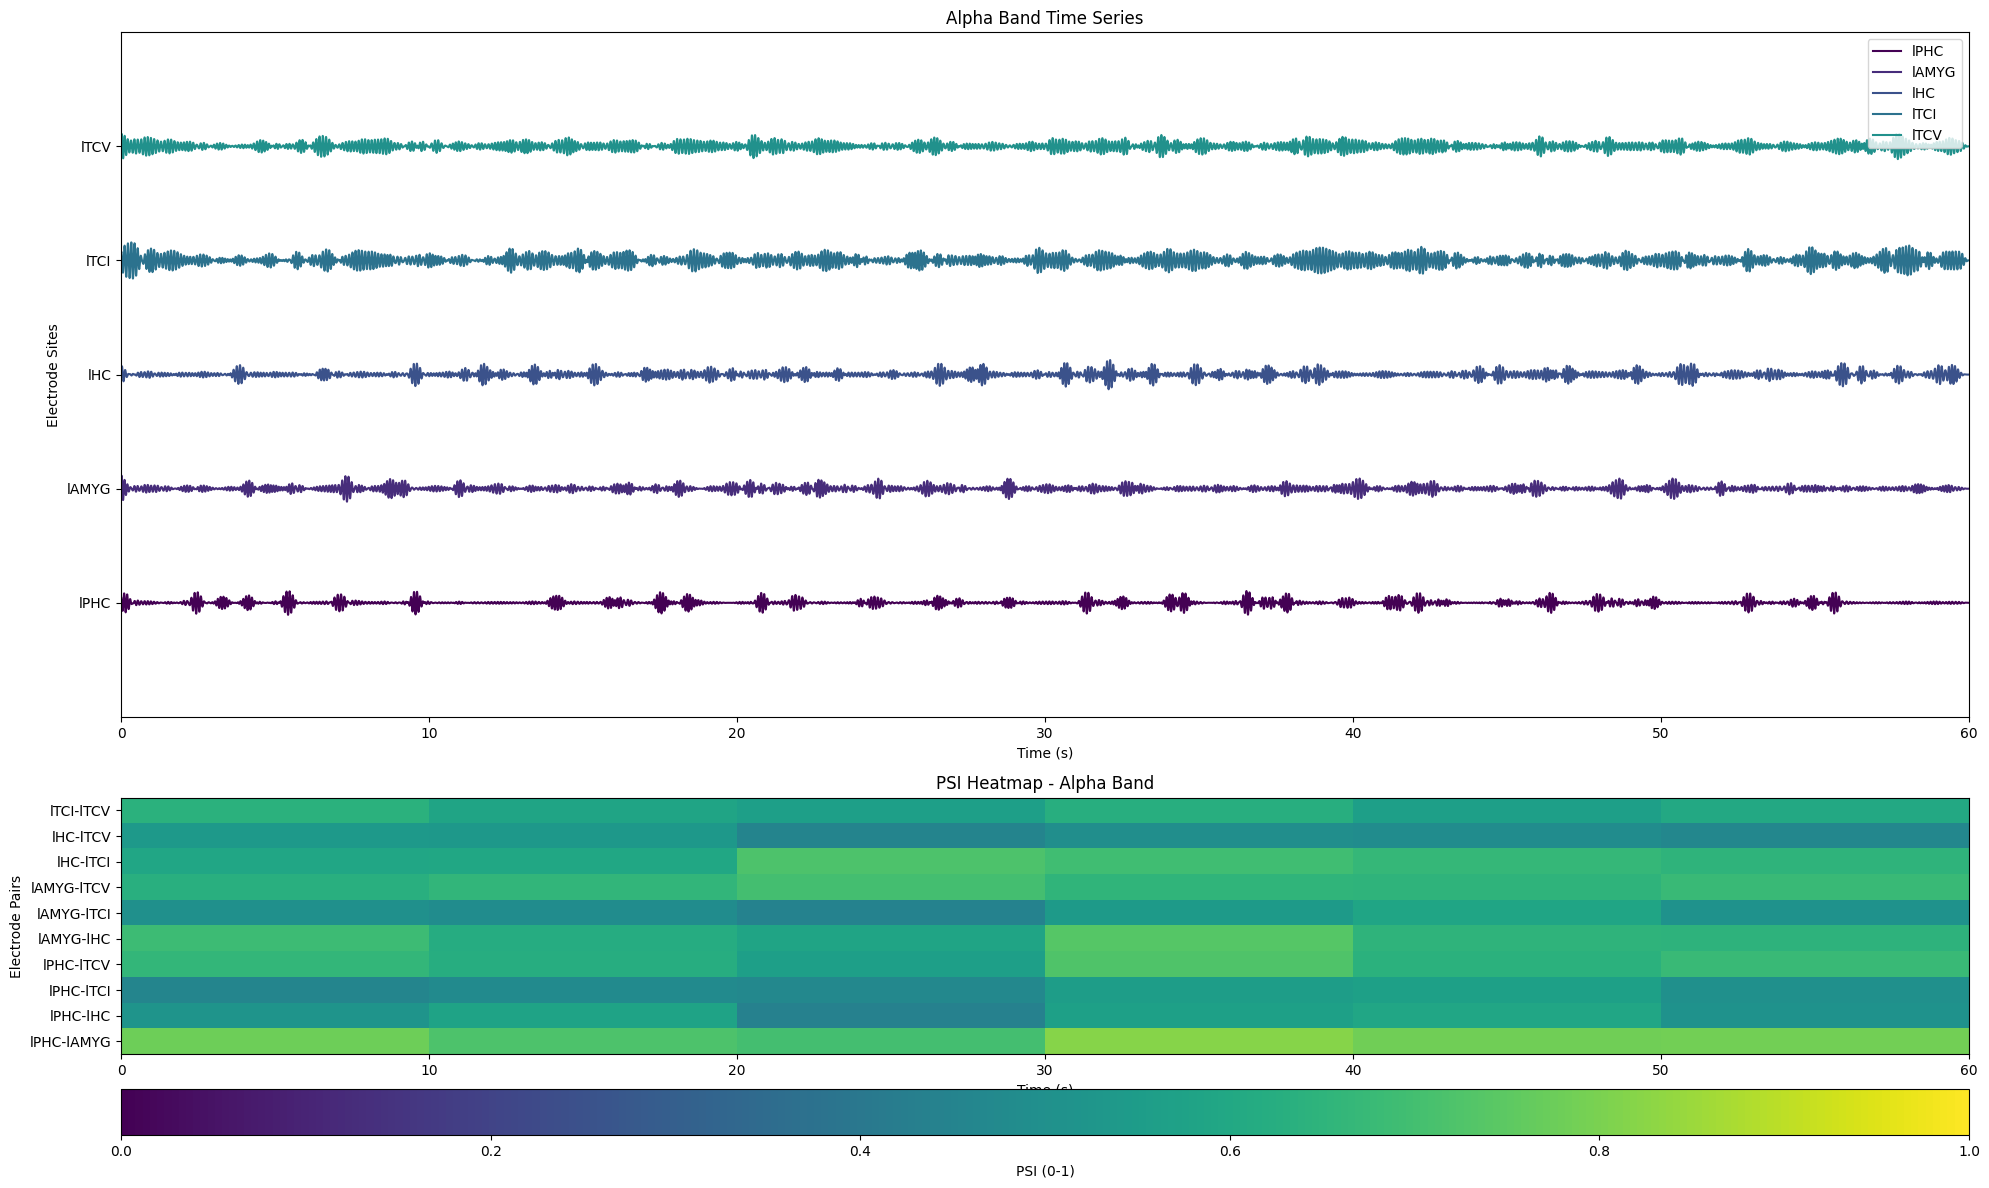

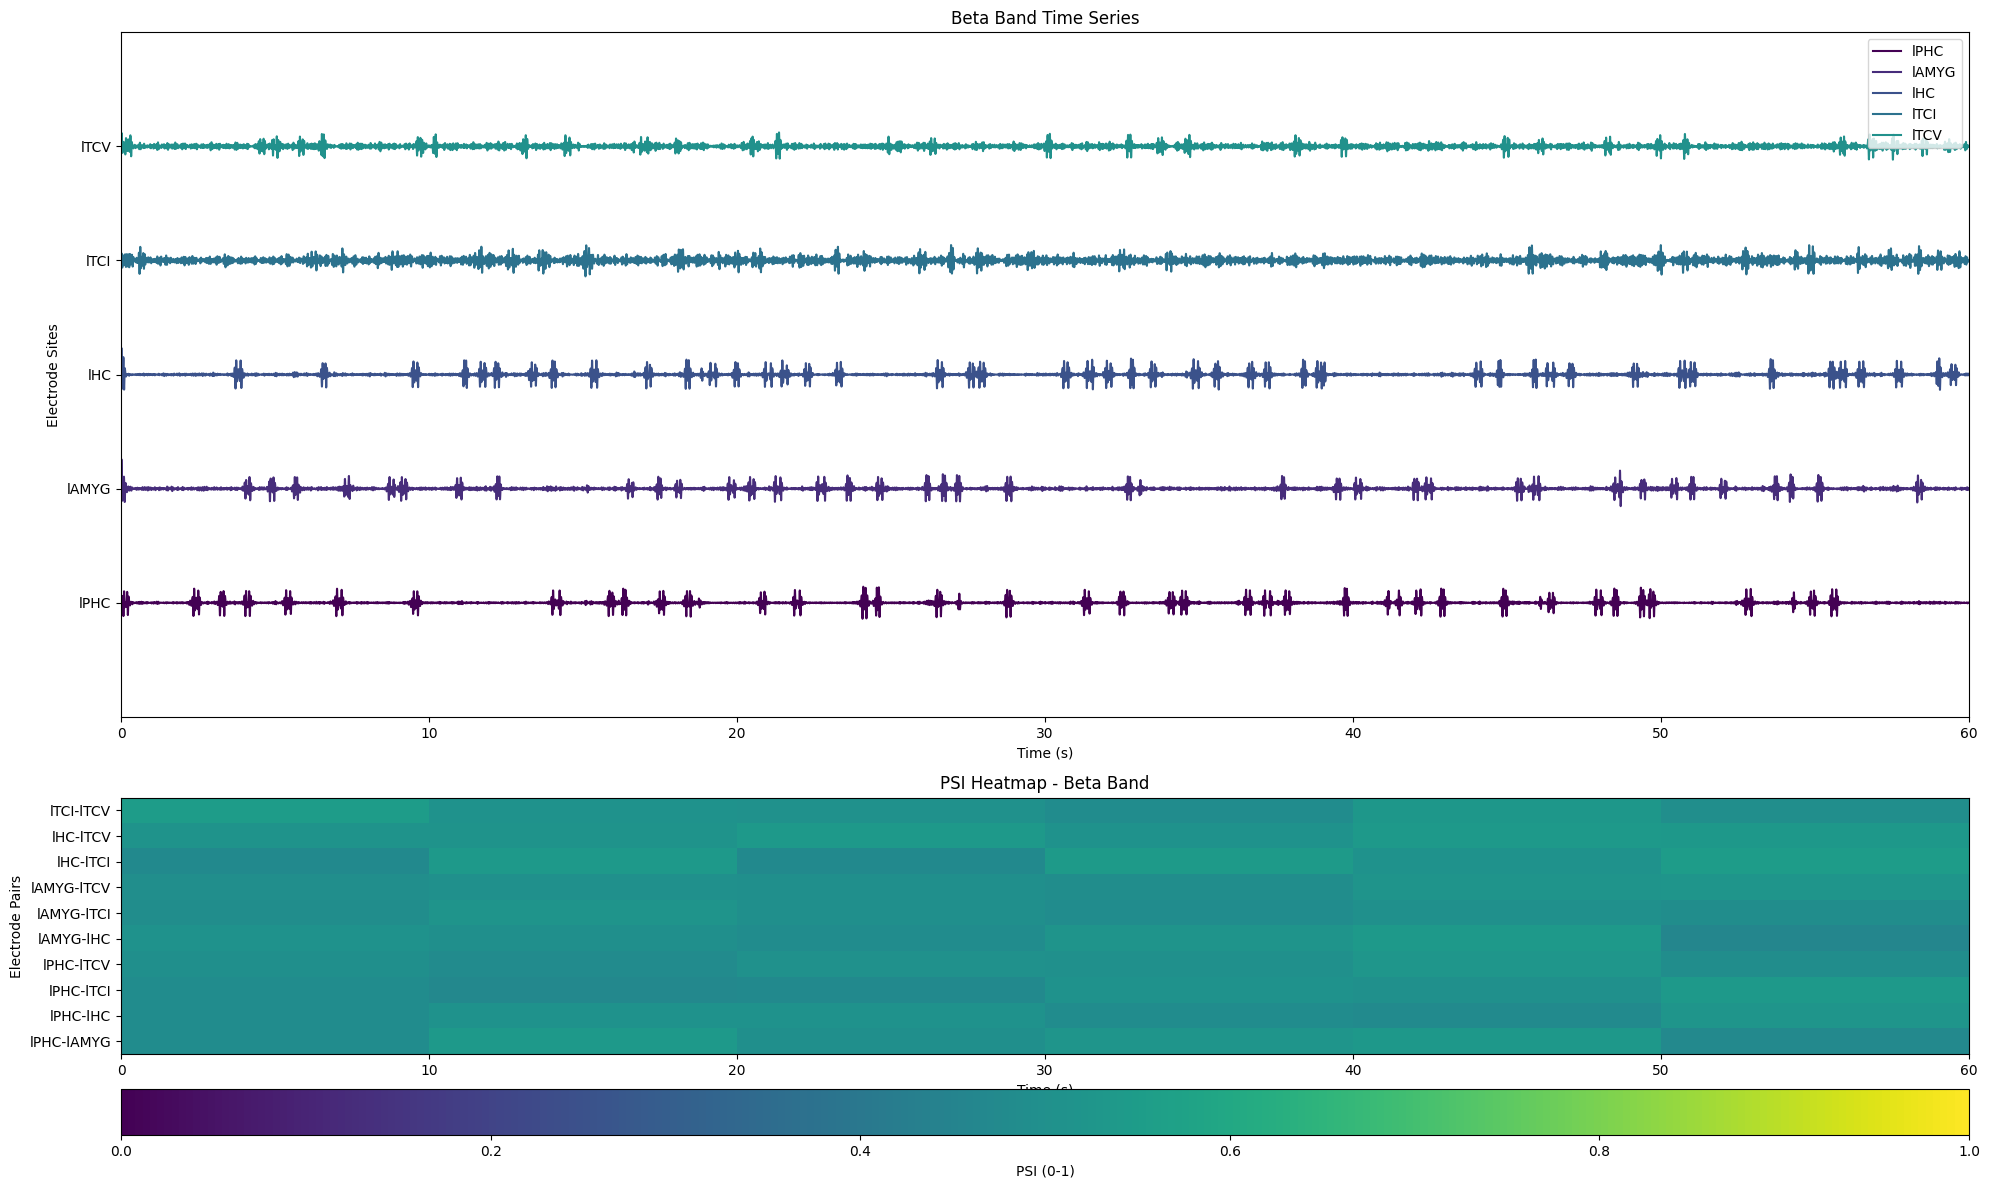

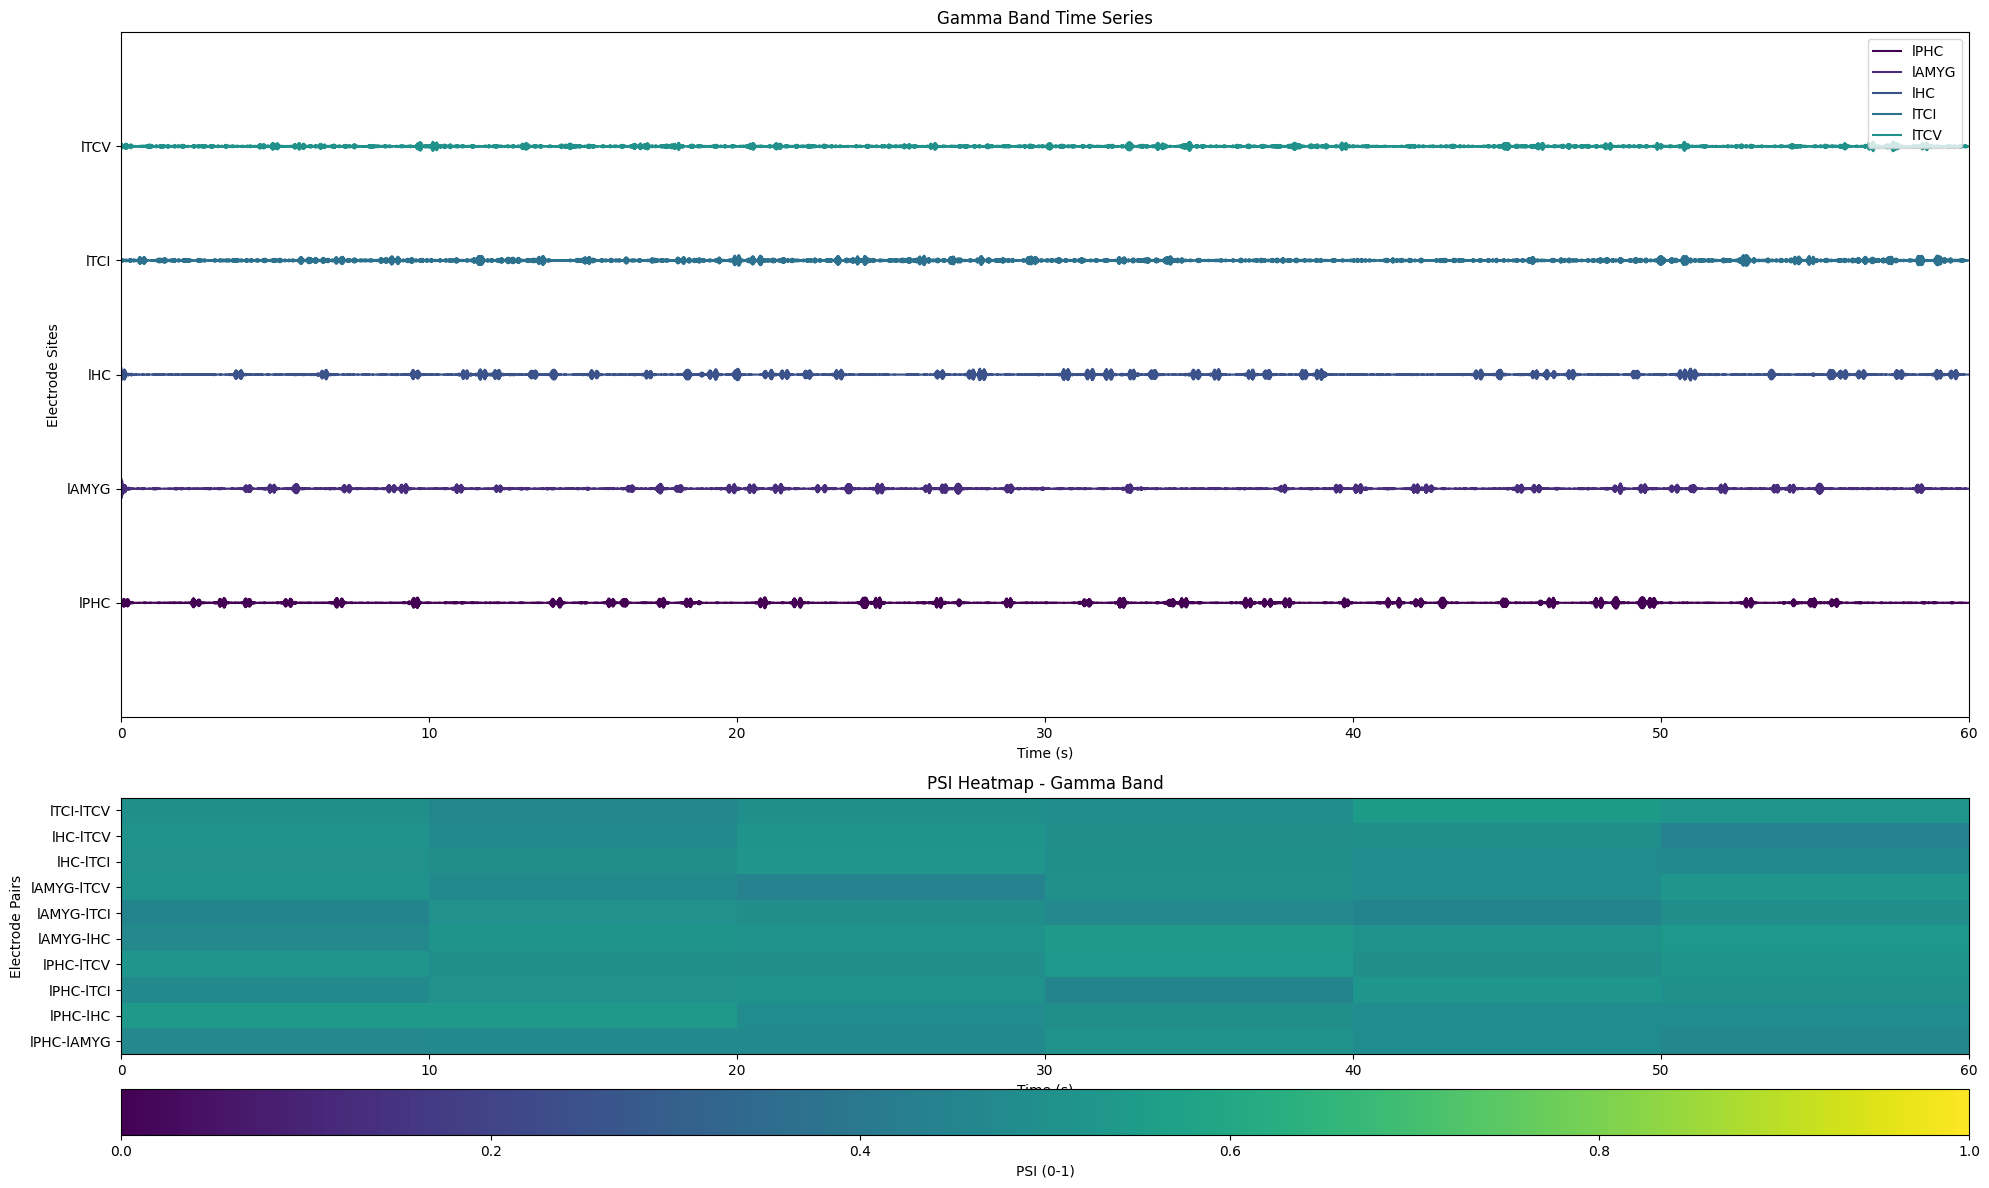

In [13]:
# Sampling frequency and electrode indices
fs = 1000  
time_sec = 60
time_samples = time_sec * fs  # Number of samples for 60 seconds
seizure_regions = [62, 40, 47, 69, 72]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV']
colors = plt.cm.viridis(np.linspace(0, .5, len(seizure_regions)))

# Define the bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

# Define frequency bands
bands = {
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (13, 30),
    'Gamma': (30, 40)
}


# Common y-axis limits and ticks for filtered data
filtered_y_lim = (-0.2, 0.2)
filtered_y_ticks = np.arange(-0.3, 0.4, 0.1)

# y-axis limits and ticks for raw data
raw_y_lim = (-.5, .5)
raw_y_ticks = np.arange(-.5, .6, 0.25)

# Function to compute Phase Synchronization Index (PSI)
def phase_sync_index(signal1, signal2):
    phase1 = np.angle(hilbert(signal1))
    phase2 = np.angle(hilbert(signal2))
    phase_diff = np.abs(np.angle(np.exp(1j * (phase1 - phase2))))
    psi = 1 - np.mean(phase_diff / np.pi)  # Normalize between 0 and 1
    return psi

# Define 10-second windows
window_size = 10 * fs  # 10 seconds in samples
step_size = window_size  # No overlap in windows
num_windows = time_samples // window_size

# Get all electrode pairs
pairs = list(combinations(seizure_regions, 2))

# Calculate PSI matrices for all bands
psi_matrices = {}
for band_name, (lowcut, highcut) in bands.items():
    psi_matrix = np.zeros((len(pairs), num_windows))
    for idx, (ch1, ch2) in enumerate(pairs):
        for w in range(num_windows):
            start = w * step_size
            end = start + window_size
            psi_matrix[idx, w] = phase_sync_index(
                bandpass_filter(DATA[start:end, ch1], lowcut, highcut, fs),
                bandpass_filter(DATA[start:end, ch2], lowcut, highcut, fs)
            )
    psi_matrices[band_name] = psi_matrix

# Plot raw time series
plt.figure(figsize=(20, 12))
for i, (region_idx, color) in enumerate(zip(seizure_regions, colors)):
    plt.subplot(5, 1, i + 1)
    plt.plot(np.arange(0, time_samples) / fs, DATA[:time_samples, region_idx], color=color)
    plt.title(f'Raw Time Series: {names[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(raw_y_lim)
    plt.yticks(raw_y_ticks)
plt.tight_layout()
plt.show()

# Function to plot filtered time series and PSI heatmaps
def plot_filtered_and_psi(band_name, lowcut, highcut):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 1]})

    # Plot filtered time series
    y_positions = np.linspace(0, len(seizure_regions) - 1, len(seizure_regions))
    for i, (region_idx, color) in enumerate(zip(seizure_regions, colors)):
        filtered_data = bandpass_filter(DATA[:time_samples, region_idx], lowcut, highcut, fs)
        ax[0].plot(np.arange(0, time_samples) / fs, filtered_data * 1.5 + y_positions[i], color=color, label=names[i])
    
    ax[0].set_title(f'{band_name} Band Time Series')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Electrode Sites')
    ax[0].set_yticks(y_positions)
    ax[0].set_yticklabels(names)
    ax[0].set_ylim(min(y_positions) - 1, max(y_positions) + 1)
    ax[0].set_xlim(0, 60)
    ax[0].legend(loc='upper right')

    # Plot PSI heatmap
    psi_matrix = psi_matrices[band_name]
    cax = ax[1].imshow(psi_matrix, aspect='auto', cmap='viridis', extent=[0, time_sec, 0, len(pairs)], vmin=0, vmax=1)
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Electrode Pairs')
    ax[1].set_yticks(np.arange(len(pairs)) + 0.5)
    ax[1].set_yticklabels([f'{names[seizure_regions.index(ch1)]}-{names[seizure_regions.index(ch2)]}' for ch1, ch2 in pairs])
    ax[1].set_title(f'PSI Heatmap - {band_name} Band')
    ax[1].set_xlim(0, 60)
    
    # Add color bar at the bottom
    cbar = plt.colorbar(cax, ax=ax[1], orientation='horizontal', pad=0.1, aspect=40)
    cbar.set_label('PSI (0-1)')
    
    plt.tight_layout()
    plt.show()

# Plot filtered time series and PSI heatmaps for each band in the specified order
for band_name, (lowcut, highcut) in bands.items():
    plot_filtered_and_psi(band_name, lowcut, highcut)
